In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [36]:
locloc = "PreparedNp" 
namename = "\Cube"
all_photos = np.load(locloc + namename + 'Photos.npy')
all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')
#all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [182]:
def masstest(mylist, locmodel):
    numlist = mylist 
    intotheflames = list()
    testanswers = list()
    
    intotheflames.append(all_photos[numlist])
    for i in numlist:
        testanswers.append(all_photos[i] - answerList[i])

    
    intotheflames = np.array(intotheflames)[0]
    testanswers = np.array(testanswers)
    print(testanswers.shape)
    print(intotheflames.shape)
    imgimg = locmodel.predict(intotheflames)

    differencemap = list()
    for i in range(imgimg.shape[0]):
        differencemap.append(normalizeNegativeImage(imgimg[i], all_masks[mylist[i] // lightjumps]))
        
    imgimg = intotheflames - imgimg
    imgimg = np.clip(imgimg, 0 ,1)
    testanswers = np.clip(testanswers, 0 ,1)
    
    r0 =  np.concatenate(np.take(intotheflames, [0,1,2,3,4,5,6,7], axis=0), axis=1)
    r1 =  np.concatenate(np.take(imgimg, [0,1,2,3,4,5,6,7], axis=0), axis=1)
    r2 =  np.concatenate(np.take(testanswers, [0,1,2,3,4,5,6,7], axis=0), axis=1)
    r3 =  np.concatenate(np.take(differencemap, [0,1,2,3,4,5,6,7], axis=0), axis=1)
    #r3 =  np.concatenate(np.take(intotheflames, [4,5,6,7], axis=0), axis=0)
    #r4 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=0)
    #r5 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=0)
    finalimage = np.concatenate([r0, r3, r1, r2], axis=0)
                                 #r3,r4, r5], 
    return finalimage

(100, 64, 64)


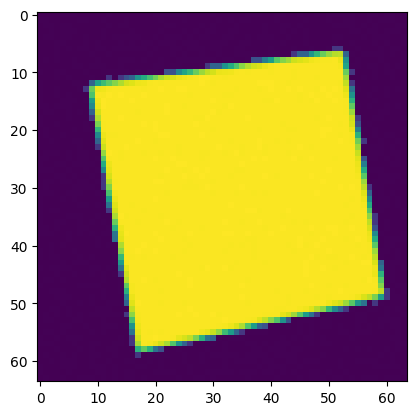

In [38]:
all_one_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]
all_one_masks *= (1.0/all_one_masks.max())
plt.imshow(all_one_masks[0])
print(all_one_masks.shape)

In [102]:
batch_size = 64
train_size = int(0.95 * len(all_photos)) # SMALL DATASET FOR TESTING

lightjumps = 77
answerList = list()
print(len(all_photos))
for i in range(len(all_photos)):
    answerList.append(
        GetDifference(i, lightjumps)
    )
            
        
answerList = np.array(answerList)

dataset = tf.data.Dataset.from_tensor_slices((all_photos, answerList))
dataset = dataset.shuffle(buffer_size=512, seed=42)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(64, drop_remainder=True)
test_dataset = test_dataset.batch(64,drop_remainder=True)
print(all_photos.shape, answerList.shape)

7700
(7700, 64, 64, 3) (7700, 64, 64, 3)


In [101]:
def GetDifference(num_images, light_jumps):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images // light_jumps]
    mask = all_masks[num_images // light_jumps]
    return photo - albedo * mask

In [149]:
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nonneg = nonneg * (1.0/nonneg.max())
    return nonneg * mask

114 6


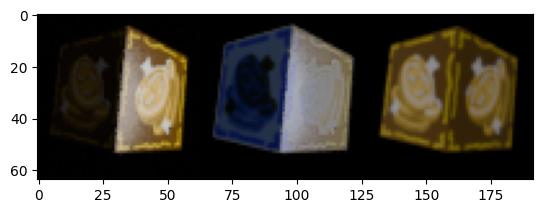

In [141]:
print(len(list(train_dataset)), len(list(test_dataset)))
def PhotoNormalMask(imtoshownum):
    imtoshow = np.concatenate( [
        all_photos[imtoshownum], 
        normalizeNegativeImage(imtoshownum), 
        all_photos[imtoshownum] - answerList[imtoshownum]
        #np.repeat(answerList[imtoshownum][...,3:], 3, axis=2) 
    ]
                              , axis=1).astype("float32")
    plt.imshow(imtoshow)
PhotoNormalMask(1900)

In [54]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.000022)

In [61]:
model = keras.Sequential([
    keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3 * 32 * 32, activation='tanh'),
    keras.layers.Reshape((32, 32, 3)),
    keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh'),
])
model.compile(optimizer=g_optimizer_image, loss="mse")
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 32, 32, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 8, 8, 16)       

In [161]:
model.fit(train_dataset, epochs=200)

Epoch 1/200
114/114 [==============================] - 2s 12ms/step - loss: 0.0036
Epoch 2/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 3/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 4/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 5/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 6/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 7/200
114/114 [==============================] - 1s 13ms/step - loss: 0.0036
Epoch 8/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 9/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 10/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 11/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 12/200
114/114 [==============================] - 1s 12ms/step - loss: 0.0036
E

(8, 64, 64, 3)
(8, 64, 64, 3)
1/1 [==============================] - 0s 23ms/step
(256, 512, 3)


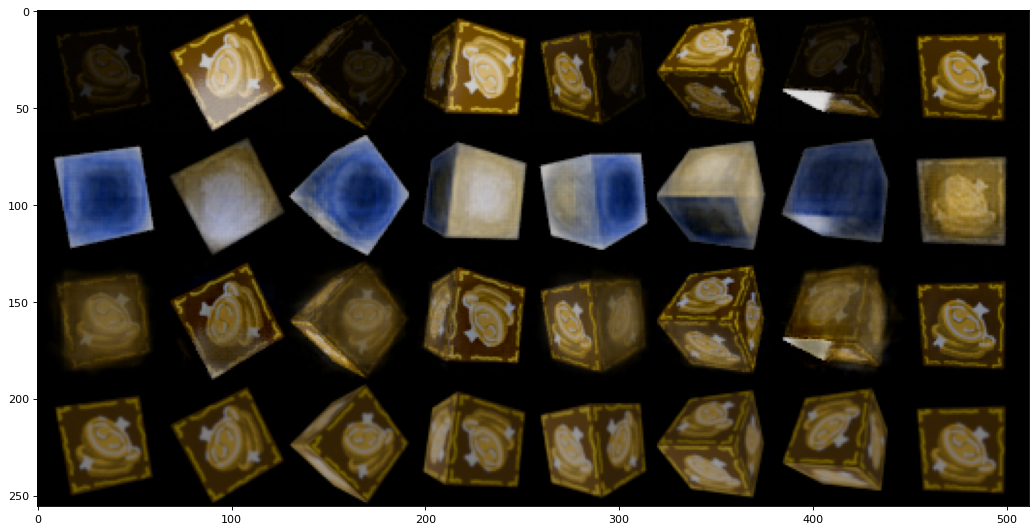

In [187]:
toinset = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
bigpicture = masstest(toinset, model)
print(bigpicture.shape)
plt.figure(figsize=(16, 10), dpi=80)
plt.imshow(bigpicture.astype("float32"))

In [189]:
model.evaluate(train_dataset)

114/114 [==============================] - 1s 8ms/step - loss: 0.0022


0.0021730302833020687

In [191]:
#model.save("CubeAlbedos001.keras")

In [192]:
# 1 Итерация идеи: Засунуть все вместе в котел и оставить вариться, результаты ничего так, но мне не нравилась ошибка
# 2 Итерация идеи: Вероятнее всего лучше обучить нейронку находить разницу между двумя изображениями
# В целом ничего так получилось, но у модели проблемы с бликами, что в целом объяснимо т.к. из них почти невозможно восстановить информацию